In [1]:
import os
import pandas as pd
import numpy as np

import cudf
import nvtabular as nvt

In [2]:
DATA_FOLDER = "/workspace/yoochoose-data"
FILENAME_PATTERN = 'yoochoose-clicks.dat'
DATA_PATH = os.path.join(DATA_FOLDER, FILENAME_PATTERN)

!ls $DATA_PATH

/workspace/yoochoose-data/yoochoose-clicks.dat


In [3]:

#Accepted data formats are: csv | tsv | parquet
DATA_FORMAT = 'csv' 
#List of columns names to be used for CSV / TSV files without the header line
HEADLESS_CSV_COLUMN_NAMES = ['session_id','timestamp', 'item_id', 'category']

In [4]:
DATA_FORMAT = 'csv' 
if DATA_FORMAT == 'parquet':
    gdf = cudf.read_parquet(DATA_PATH)
    
elif DATA_FORMAT in ['csv', 'tsv']:
    gdf = cudf.read_csv(DATA_PATH,                              
                             sep='\t' if DATA_FORMAT == 'tsv' else ',',
                             names=HEADLESS_CSV_COLUMN_NAMES
                            )

In [5]:
gdf.head()

,session_id,timestamp,item_id,category
0,1,2014-04-07T10:51:09.277Z,214536502,0
1,1,2014-04-07T10:54:09.868Z,214536500,0
2,1,2014-04-07T10:54:46.998Z,214536506,0
3,1,2014-04-07T10:57:00.306Z,214577561,0
4,2,2014-04-07T13:56:37.614Z,214662742,0


In [8]:
gdf_grouped = gdf.groupby('item_id').agg({'timestamp': 'min'}).reset_index().rename(columns={'timestamp': 'itemid_ts_first'})

In [9]:
gdf_grouped.head()

,item_id,itemid_ts_first
0,214858691,2014-09-26T14:50:12.011Z
1,214512459,2014-05-28T19:29:41.227Z
2,214541362,2014-06-05T06:09:33.034Z
3,214843680,2014-04-01T06:04:30.903Z
4,214682154,2014-04-01T09:42:39.407Z


In [11]:
gdf_merged = gdf.merge(gdf_grouped, on=['item_id'], how='left')

In [12]:
gdf_merged.head()

,session_id,timestamp,item_id,category,itemid_ts_first
0,9669,2014-04-07T13:42:46.947Z,214545879,0,2014-04-01T06:00:30.723Z
1,9669,2014-04-07T13:43:59.998Z,214545879,0,2014-04-01T06:00:30.723Z
2,9668,2014-04-01T19:26:28.112Z,214584920,0,2014-04-01T03:31:11.265Z
3,9668,2014-04-01T19:26:45.677Z,214677984,0,2014-04-01T07:05:54.632Z
4,9668,2014-04-01T19:28:05.933Z,214701812,0,2014-04-01T07:17:42.080Z


In [13]:
gdf_merged.shape

(33003944, 5)

In [62]:
gdf_merged.session_id.nunique()

9249729

In [14]:
# create time features
sessionTime = (
    ['timestamp'] >> 
    nvt.ops.LambdaOp(lambda col: col.astype('datetime64[ms]')) 
)

sessionTime_hour = (
    sessionTime >> 
    (lambda col: cudf.to_datetime(col, unit='ms').dt.hour) >> 
    nvt.ops.Rename(postfix = '_hour')
)
sessionTime_weekday = (
    sessionTime >> 
    (lambda col: cudf.to_datetime(col, unit='ms').dt.weekday) >> 
    nvt.ops.Rename(postfix = '_wd')
)
sessionTime_day = (
    sessionTime >> 
    nvt.ops.LambdaOp(lambda col: col.dt.day) >> 
    nvt.ops.Rename(postfix="_day")
)
sessionTime_month = (
    sessionTime >> 
    nvt.ops.LambdaOp(lambda col: col.dt.month) >> 
    nvt.ops.Rename(postfix="_month")
)
sessionTime_year = (
    sessionTime >> 
    nvt.ops.LambdaOp(lambda col: col.dt.year) >> 
    nvt.ops.Rename(postfix="_year")
)

In [15]:
def get_cycled_feature_value_sin(col, max_value):
    value_scaled = (col + 0.000001) / max_value
    value_sin = np.sin(2*np.pi*value_scaled)
    return value_sin

def get_cycled_feature_value_cos(col, max_value):
    value_scaled = (col + 0.000001) / max_value
    value_cos = np.cos(2*np.pi*value_scaled)
    return value_cos

In [16]:
hour_sin = sessionTime_hour >> (lambda col: get_cycled_feature_value_sin(col, 24)) >> nvt.ops.Rename(postfix = '_sin')
hour_cos = sessionTime_hour >> (lambda col: get_cycled_feature_value_cos(col, 24)) >> nvt.ops.Rename(postfix = '_cos')
weekday_sin = sessionTime_weekday >> (lambda col: get_cycled_feature_value_sin(col+1, 7)) >> nvt.ops.Rename(postfix = '_sin')
weekday_cos= sessionTime_weekday >> (lambda col: get_cycled_feature_value_cos(col+1, 7)) >> nvt.ops.Rename(postfix = '_cos')

In [17]:
cycled_features = hour_sin + hour_cos + weekday_sin + weekday_cos

In [18]:
cycled_features.columns

['timestamp_hour_sin',
 'timestamp_hour_cos',
 'timestamp_wd_sin',
 'timestamp_wd_cos']

In [19]:
# standar scale the cycled_features
cycled_features_norm = cycled_features >> nvt.ops.Normalize() >> nvt.ops.Rename(postfix = '_norm')

In [20]:
# calculate item recency 
# create custom op
from nvtabular.ops import Operator

class ItemRecency(Operator):
    def transform(self, columns, gdf):
        for column in columns:
            col = gdf[column]
            col.loc[col == ""] = None
            col = col.astype('datetime64[ms]')
            timestamp = (gdf['timestamp']).astype('datetime64[ms]')
            delta = (timestamp - col).dt.days
            gdf[column + "_age_days"] = delta * (delta >=0)
        return gdf
            
    def output_column_names(self, columns):
        return [column + "_age_days" for column in columns]
            
    def dependencies(self):
        return ["timestamp"]

In [21]:
# process dates using the ‘DaysSincePublished’ custom operator
dates = ["itemid_ts_first"]
recency_features = dates >> ItemRecency() 
recency_features_norm = recency_features >> nvt.ops.LogOp() >> nvt.ops.Normalize() >> nvt.ops.Rename(postfix = '_norm')

In [31]:
recency_features.columns, recency_features_norm.columns

(['itemid_ts_first_age_days'], ['itemid_ts_first_age_days_norm'])

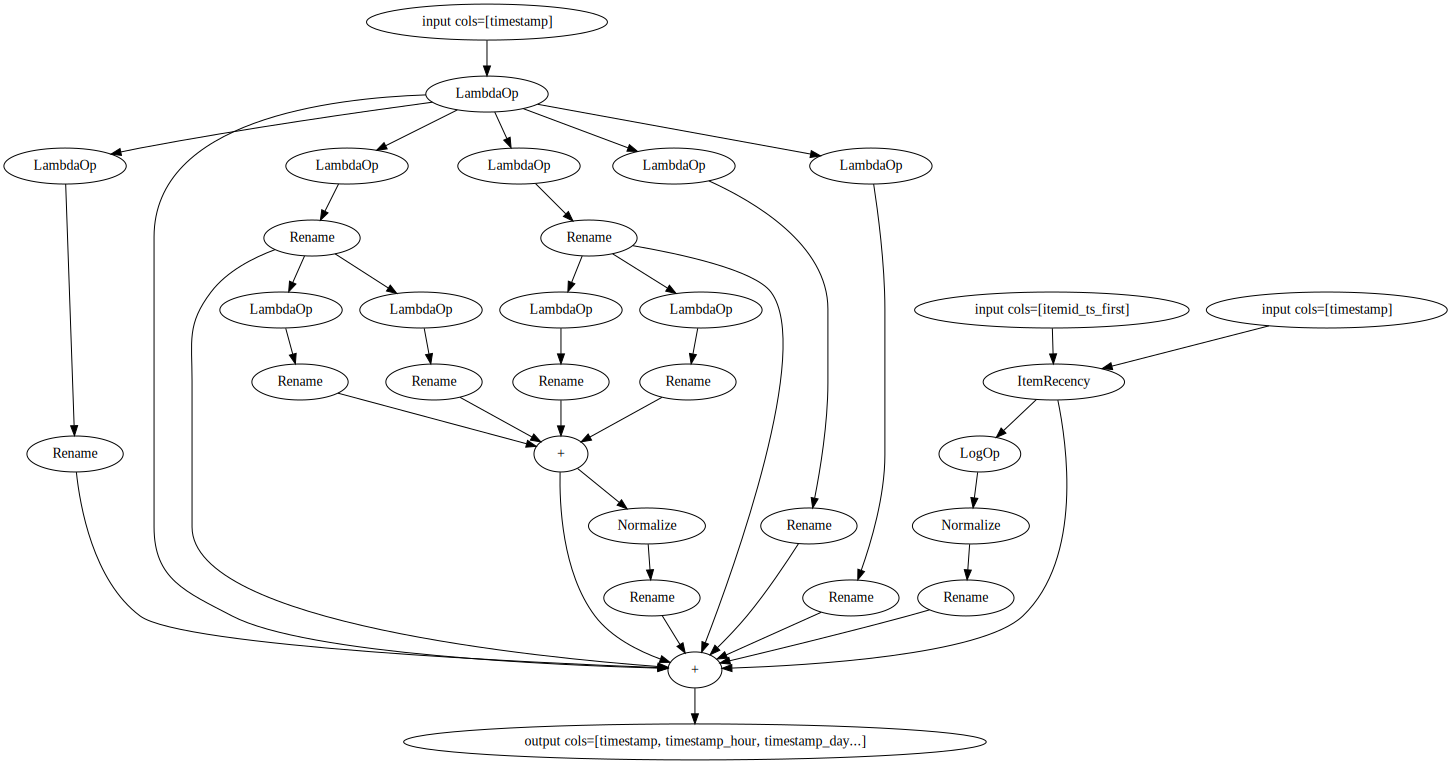

In [23]:
 time_features = (
    sessionTime + 
    sessionTime_hour +
    sessionTime_day + 
    sessionTime_month + 
    sessionTime_year +
    sessionTime_weekday +
    recency_features +
    recency_features_norm + 
    cycled_features +
    cycled_features_norm
)
time_features.graph

In [24]:
time_features.columns

['timestamp',
 'timestamp_hour',
 'timestamp_day',
 'timestamp_month',
 'timestamp_year',
 'timestamp_wd',
 'itemid_ts_first_age_days',
 'itemid_ts_first_age_days_norm',
 'timestamp_hour_sin',
 'timestamp_hour_cos',
 'timestamp_wd_sin',
 'timestamp_wd_cos',
 'timestamp_hour_sin_norm',
 'timestamp_hour_cos_norm',
 'timestamp_wd_sin_norm',
 'timestamp_wd_cos_norm']

Index(['timestamp', 'timestamp_hour', 'timestamp_day', 'timestamp_month',
       'timestamp_year', 'timestamp_wd', 'itemid_ts_first_age_days',
       'itemid_ts_first_age_days_norm', 'timestamp_hour_sin',
       'timestamp_hour_cos', 'timestamp_wd_sin', 'timestamp_wd_cos',
       'timestamp_hour_sin_norm', 'timestamp_hour_cos_norm',
       'timestamp_wd_sin_norm', 'timestamp_wd_cos_norm', 'session_id',
       'item_id', 'category'],
      dtype='object')

In [37]:
dataset = nvt.Dataset(gdf, cpu=False)

keys = ["session_id"]
# Define Groupby Workflow
groupby_features = (['item_id', 'category'] >> nvt.ops.Categorify()) + ['session_id']+ time_features >> nvt.ops.Groupby(
    groupby_cols=keys, 
    sort_cols=["timestamp"],
    aggs={
        "item_id": ["list"],
        "category": ["list"],
        "timestamp": ["list", "first", "last"],
        'timestamp_day': ["list"],
        'timestamp_hour': ["list"],
        'timestamp_month': ["list"],
        'timestamp_wd': ["list"],
        'itemid_ts_first_age_days': ["list"],
        'itemid_ts_first_age_days_norm': ["list"],
        'timestamp_hour_sin': ["list"],
        'timestamp_hour_sin_norm': ["list"],
        'timestamp_hour_cos': ["list"],
        'timestamp_hour_cos_norm': ["list"],
        'timestamp_wd_sin': ["list"],
        'timestamp_wd_sin_norm': ["list"],
        'timestamp_wd_cos': ["list"],
        'timestamp_wd_cos_norm': ["list"],
        
        },
    name_sep="-")

In [48]:
remaining_columns = [x for x in groupby_features.columns if x!= 'timestamp-first']
remaining_columns

['timestamp_hour_cos_norm-list',
 'item_id-list',
 'session_id',
 'timestamp_hour_cos-list',
 'timestamp_wd-list',
 'timestamp-list',
 'timestamp_wd_cos_norm-list',
 'timestamp_wd_sin-list',
 'timestamp_day-list',
 'timestamp_wd_cos-list',
 'timestamp_hour_sin_norm-list',
 'itemid_ts_first_age_days_norm-list',
 'timestamp-last',
 'timestamp_hour_sin-list',
 'category-list',
 'timestamp_month-list',
 'itemid_ts_first_age_days-list',
 'timestamp_hour-list',
 'timestamp_wd_sin_norm-list']

In [51]:
(groupby_features - remaining_columns)

['timestamp-first']

In [72]:
# calculate day index based on 'timestamp-first' column
day_index = ( (groupby_features - remaining_columns)  >> 
    nvt.ops.LambdaOp(lambda col: (col - col.min()).dt.days +1) >> 
    nvt.ops.Rename(postfix="_day_index")
)

In [64]:
workflow = nvt.Workflow(groupby_features + day_index)

In [65]:
workflow.column_group.columns

['timestamp_hour_cos_norm-list',
 'item_id-list',
 'session_id',
 'timestamp_hour_cos-list',
 'timestamp-first',
 'timestamp_wd-list',
 'timestamp-list',
 'timestamp_wd_cos_norm-list',
 'timestamp_wd_sin-list',
 'timestamp_day-list',
 'timestamp_wd_cos-list',
 'timestamp_hour_sin_norm-list',
 'itemid_ts_first_age_days_norm-list',
 'timestamp-last',
 'timestamp_hour_sin-list',
 'category-list',
 'timestamp_month-list',
 'itemid_ts_first_age_days-list',
 'timestamp_hour-list',
 'timestamp_wd_sin_norm-list',
 'timestamp-first_day_index']

In [66]:
dataset = nvt.Dataset(gdf_merged, cpu=False)
workflow.fit(dataset)
new_gdf = workflow.transform(dataset).to_ddf().compute()

In [67]:
new_gdf.head(10)

,timestamp_hour_cos_norm-list,item_id-list,session_id,timestamp_hour_cos-list,timestamp-first,timestamp_wd-list,timestamp-list,timestamp_wd_cos_norm-list,timestamp_wd_sin-list,timestamp_day-list,...,timestamp_hour_sin_norm-list,itemid_ts_first_age_days_norm-list,timestamp-last,timestamp_hour_sin-list,category-list,timestamp_month-list,itemid_ts_first_age_days-list,timestamp_hour-list,timestamp_wd_sin_norm-list,timestamp-first_day_index
0,"[-0.9826049, -0.9826049, -0.9826049, -0.9826049]","[2054, 2053, 2055, 9877]",1,"[-0.8660256, -0.8660256, -0.8660256, -0.8660256]",2014-04-07 10:51:09.277,"[0, 0, 0, 0]","[2014-04-07T10:51:09.277, 2014-04-07T10:54:09....","[0.6580047, 0.6580047, 0.6580047, 0.6580047]","[0.7818321, 0.7818321, 0.7818321, 0.7818321]","[7, 7, 7, 7]",...,"[0.8815278, 0.8815278, 0.8815278, 0.8815278]","[-1.2462238, -1.2462238, -1.3775287, -1.3775287]",2014-04-07 10:57:00.306,"[0.49999964, 0.49999964, 0.49999964, 0.49999964]","[1, 1, 1, 1]","[4, 4, 4, 4]","[6, 6, 5, 5]","[10, 10, 10, 10]","[1.1729306, 1.1729306, 1.1729306, 1.1729306]",7
1,"[-1.1578012, -1.1578012, -1.1578012, -1.157801...","[19449, 19449, 40789, 32517, 32523, 4854]",2,"[-0.96592575, -0.96592575, -0.96592575, -0.965...",2014-04-07 13:56:37.614,"[0, 0, 0, 0, 0, 0]","[2014-04-07T13:56:37.614, 2014-04-07T13:57:19....","[0.6580047, 0.6580047, 0.6580047, 0.6580047, 0...","[0.7818321, 0.7818321, 0.7818321, 0.7818321, 0...","[7, 7, 7, 7, 7, 7]",...,"[-0.13563845, -0.13563845, -0.13563845, -0.135...","[-1.2462238, -1.2462238, -2.3133218, -2.313321...",2014-04-07 14:02:36.889,"[-0.2588193, -0.2588193, -0.2588193, -0.258819...","[1, 1, 1, 1, 1, 1]","[4, 4, 4, 4, 4, 4]","[6, 6, 1, 1, 1, 6]","[13, 13, 13, 13, 14, 14]","[1.1729306, 1.1729306, 1.1729306, 1.1729306, 1...",7
2,"[-1.1578012, -1.1578012, -1.1578012]","[28990, 35311, 43179]",3,"[-0.96592575, -0.96592575, -0.96592575]",2014-04-02 13:17:46.940,"[2, 2, 2]","[2014-04-02T13:17:46.940, 2014-04-02T13:26:02....","[-1.3648345, -1.3648345, -1.3648345]","[0.43388295, 0.43388295, 0.43388295]","[2, 2, 2]",...,"[-0.13563845, -0.13563845, -0.13563845]","[-2.3133218, -2.3133218, -2.3133218]",2014-04-02 13:30:12.318,"[-0.2588193, -0.2588193, -0.2588193]","[1, 1, 1]","[4, 4, 4]","[1, 1, 1]","[13, 13, 13]","[0.6328651, 0.6328651, 0.6328651]",2
3,"[-1.2175578, -1.2175578]","[44326, 26362]",4,"[-1.0, -1.0]",2014-04-07 12:09:10.948,"[0, 0]","[2014-04-07T12:09:10.948, 2014-04-07T12:26:25....","[0.6580047, 0.6580047]","[0.7818321, 0.7818321]","[7, 7]",...,"[0.21129768, 0.21129768]","[-1.2462238, -1.2462238]",2014-04-07 12:26:25.416,"[-5.6425995e-07, -5.6425995e-07]","[1, 1]","[4, 4]","[6, 6]","[12, 12]","[1.1729306, 1.1729306]",7
4,"[-0.3406998, 0.08226263]","[25633, 41161]",6,"[-0.4999995, -0.25881854]",2014-04-06 16:58:20.848,"[6, 6]","[2014-04-06T16:58:20.848, 2014-04-06T17:02:26....","[1.1576058, 1.1576058]","[1.1285199e-06, 1.1285199e-06]","[6, 6]",...,"[-0.94957423, -1.0834864]","[-1.3775287, -1.3775287]",2014-04-06 17:02:26.976,"[-0.8660257, -0.965926]","[1, 1]","[4, 4]","[5, 5]","[16, 17]","[-0.040579867, -0.040579867]",6
5,"[0.5361559, 0.5361559]","[41233, 41185]",7,"[-2.8212997e-07, -2.8212997e-07]",2014-04-02 06:38:53.104,"[2, 2]","[2014-04-02T06:38:53.104, 2014-04-02T06:39:05....","[-1.3648345, -1.3648345]","[0.43388295, 0.43388295]","[2, 2]",...,"[1.5517582, 1.5517582]","[-2.3133218, -2.3133218]",2014-04-02 06:39:05.854,"[1.0, 1.0]","[1, 1]","[4, 4]","[1, 1]","[6, 6]","[0.6328651, 0.6328651]",2
6,"[-0.34070122, -0.34070122]","[45038, 45038]",8,"[-0.5000003, -0.5000003]",2014-04-06 08:49:58.728,"[6, 6]","[2014-04-06T08:49:58.728, 2014-04-06T08:52:12....","[1.1576058, 1.1576058]","[1.1285199e-06, 1.1285199e-06]","[6, 6]",...,"[1.3721704, 1.3721704]","[-1.3775287, -1.3775287]",2014-04-06 08:52:12.647,"[0.86602527, 0.86602527]","[1, 1]","[4, 4]","[5, 5]","[8, 8]","[-0.040579867, -0.040579867]",6
7,"[-1.1578016, -1.1578016, -1.1578016]","[9614, 9614, 9614]",9,"[-0.96592593, -0.96592593, -0.96592593]",2014-04-06 11:26:2

In [68]:
new_gdf['timestamp-first_day_index'].min(), new_gdf['timestamp-first_day_index'].max()

(1, 182)

In [69]:
# Convert to a Datset and write out hive-partitioned data to disk
path ='./output_day/'
nvt.Dataset(new_gdf).to_parquet(path, partition_on=['timestamp-first_day_index'])